# How to Solve a Basic Dynamic Programming Problem

This notebook will demonstrate how to solve a class of problems commonly encountered in economics. The application will be a simple income fluctuation problem that is widely known and forms the basis of many heterogeneous agents models. Hopefully, this code is straightforward to extend to new economic setups.

There are many ways of solving these types of problems. The method we will discuss is the most intuitive and a great starting point for learning about more advanced techniques. Moreover, it is particularly well-suited for Julia. It will highlight the following features:

* Fast loops
* The type system
* Some useful packages
* Easy parallelization

## Economic Environment

Consider an infinitely-lived household who seeks to choose a plan for consumption $\{c_t\}_{t=1}^{\infty}$ to maximize:
$$
\mathbb{E} \displaystyle \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to 
\begin{align*}
c_t + a_{t+1} &\leq (1 + r) a_t + w y_t \\
c_t &\geq 0 \\
a_t &\geq 0
\end{align*}

The budget constraint says that the household needs to allocate resources to consumption and savings, $a_{t+1}$. The resources it has at its disposal are its savings plus interest, $(1+r) a_t$ and its labor income, $w y_t$. Furthermore, savings are subject to a borrowing limit -- here it's zero, meaning that households can't go into debt.

The income process $y_t$ is assumed to follow a Markov chain with transition matrix $\Pi$. For example, $\Pi(y_j | y_i)$ is the probability that tomorrow's state is $y_j$ if today's state if $y_i$.

## Dynamic Programming Setup

We are looking for consumption plans and saving plans for the household under any possible state that can arise. What is a state here? It consists of:

1. Income $y_t$: today's income determines how much cash-in-hand the household has and is used to forecast tomorrow's income. This is the **exogenous** state, and it is not chosen by the household.
2. Current assets $a_t$: also determines how much resources are available. This is chosen by the household each period and gets carried over to next period. This is the **endogenous** state.

Let's formulate the household's problem recursively. The Bellman equation is:

$$
V(a_t, y_t) = \max_{c_t, a_{t+1}} u(c_t) + \beta \displaystyle \sum_{y_{t+1} \in Y} \Pi(y_{t+1} | y_t) V(a_{t+1}, y_{t+1})
$$

subject to 
\begin{align*}
c_t + a_{t+1} &\leq (1 + r) a_t + w y_t \\
c_t &\geq 0 \\
a_t &\geq 0
\end{align*}

We call $V(a_t, y_t)$ the **value function**. Each period, the household chooses assets and consumption to maximize the payoff from being in state $(a_t, y_t)$. This is the sum of two components:

1. The instantaneous utility it gets at time $t$ 
2. The continuation value, which represents the expected value of tomorrow's state. This depends on the level of assets the household chooses today, and an expectation is taken over the exogenous income process.

The solution to this problem will be a value function and associated policy functions for consumption and assets that satisfy the household's problem and the constraints.

## Solution Strategy

This solving this problem requires us to find an unknown *function*. To compute it, we will use an iterative method called **value function iteration**. We will start with some guess for the value function, compute the right-hand-side of the Bellman equation, and then use the new resulting function as our next guess. We will continue iterating in this fashion until our guesses converge. 

Since a computer can't store functions, we will need to approximate our guesses for value function. There are many ways to do this. Our approach here will be to record the value at a finite set of asset and income points, and linearly interpolate between those points. 

We will be more specific about the details of each step as we walk through the code. We'll first discuss how the algorithm works and then show how to parallelize it.

## Implementation

We first import the packages needed.

In [1]:
using QuantEcon
using Interpolations
using Optim
using KernelDensity
using StatsBase
using Plots
pyplot()

Plots.PyPlotBackend()

### Setting Up the Infrastructure

We are first going to set up a type, `Household`, that will store all of the parameters needed to solve the household's problem. In general, creating custom types is helpful for organizing and structuring large programs. Here, it is a clean way to pass all of the parameters to the functions we will define.

In [2]:
mutable struct Household

    # User-inputted
    β::Float64                                                        # discount factor
    y_chain::MarkovChain{Float64,Matrix{Float64},Vector{Float64}}     # income process
    r::Float64                                                        # interest rate
    w::Float64                                                        # wage
    amax::Float64                                                     # top of asset grid
    Na::Int64                                                         # number of points on asset grid
    curv::Float64                                                     # curvature of asset grid

    # Created in constructor
    a_grid::Vector{Float64}     # asset grid
    y_grid::Vector{Float64}     # income grid
    ay_grid::Matrix{Float64}    # combined asset/income grid
    ayi_grid::Matrix{Float64}   # combined asset/income index grid
    Ny::Int64                   # number of points on income grid
    V::Matrix{Float64}          # current guess for value function on grid points
    ap::Matrix{Float64}         # current guess for asset policy function on grid points
    c::Matrix{Float64}          # current guess for consumption policy function on grid points

end

The `Household` struct will store all of the exogenous parameters of the model, the grids over which we will approximate the value function, and the current guesses for the value function, asset policy function, and consumption policy function. Each of these comes paired with a *type declaration* (after the `::`). Julia does not require these, but including them avoids the need for the compiler to infer the types of each field. In many situations, this can dramatically improve the speed of the code.

The first block of fields are the parameters the user needs to specify. The second block is created by the code in the constructor. Before describing that, let's define a few functions that will be useful throughout the algorithm

In [3]:
u(c::Float64) = log(c)

function budget_constraint(a::Float64, ap::Float64, y::Float64, r::Float64, w::Float64)
    c = (1 + r)*a + w*y - ap
    return c
end

function budget_constraint(a::Float64, ap::Float64, y::Float64, h::Household)
    budget_constraint(a, ap, y, h.r, h.w)
end

budget_constraint (generic function with 2 methods)

We've set up the utility function, and also defined a function that backs out consumption from the budget constraint given a state (`a` and `y`) and a choice of assets tomorrow `ap`. The `budget_constraint` function has two methods, one that also accepts values for the interest rate and the wage, and another that accepts a `Household` type and takes the interest rate and wage from there. Based on the types of the arguments, Julia determines the appropriate method to execute. This is an example of *multiple dispatch*, one of the major features of Julia. It's useful tool for organizing different implementations of the same concept.

Next, we define the constructor function for the `Household`:

In [4]:
function Household(;β::Float64=0.96,
    y_chain::MarkovChain{Float64,Matrix{Float64},Vector{Float64}}=MarkovChain([0.5 0.5; 0.04 0.96], [0.25; 1.0]),
                   r::Float64=0.038, 
                   w::Float64=1.09,
                   amax::Float64=30.0,
                   Na::Int64=100,
                   curv::Float64=0.4)

    # Set up asset grid
    a_grid = linspace(0, amax^curv, Na).^(1/curv)

    # Parameters of income grid
    y_grid = y_chain.state_values
    Ny = length(y_grid)

    # Combined grids
    ay_grid = gridmake(a_grid, y_grid)
    ayi_grid = gridmake(1:Na, 1:Ny)

    # Set up initial guess for value function
    V = zeros(Na, Ny)
    c = zeros(Na, Ny)
    for (yi, y) in enumerate(y_grid)
        for (ai, a) in enumerate(a_grid)
            c_max = budget_constraint(a, 0.0, y, r, w)
            c[ai, yi] = c_max
            V[ai, yi] = u(c_max)/(1 - β)
        end
    end

    # Corresponding initial policy function is all zeros
    ap = zeros(Na, Ny)

    return Household(β, y_chain, r, w, amax, Na, curv, a_grid, y_grid, ay_grid, ayi_grid, Ny, V, ap, c)

end

Household

Notable features:
* All inputs (parameters) are optional, with the given defaults
* The asset grid is designed with more points closer to the borrowing constraint. In models with incomplete markets and a borrowing constraint, we expect there to be more curvature in this area. We want to have better precision in places where the policy is not as close to linear.
* The initial guess used for the value function is the present discounted value of consuming the maximum posible amount in the given state forever. In principle any guess should work, but this is a good one because it gives the value function the right shape.

### Applying the Bellman Operator

We need to be able to compute the right-hand side of the Bellman equation:

$$
V(a_t, y_t) = \max_{c_t, a_{t+1}} u(c_t) + \beta \displaystyle \sum_{y_{t+1} \in Y} \Pi(y_{t+1} | y_t) V(a_{t+1}, y_{t+1})
$$

subject to 
\begin{align*}
c_t + a_{t+1} &\leq (1 + r) a_t + w y_t \\
c_t &\geq 0 \\
a_t &\geq 0
\end{align*}

For every grid point, we need to be able to compute this maximum (we will eliminate $c_t$ using the budget constraint and maximize over $a_{t+1}$). This will involve using an optimization package. Because the optimal asset policy will not necessarily be on the grid, we need to be able to evaluate our guess for the value function at points off this grid. This will involve using an interpolation package.

Let's start off by writing a function to compute the flow value and continuation value given the indices of a set of states, `ai` and `yi`, and a choice for tomorrow's asset level, `ap`.

In [5]:
function value(h::Household, itp_V::Interpolations.GriddedInterpolation,
                           ap::Float64, ai::Int64, yi::Int64)
    
    # Interpolate value function at a', for each possible income level
    Vp = zeros(h.Ny)
    for yii = 1:h.Ny
        Vp[yii] = itp_V[ap, yii]
    end

    # Take expectations
    continuation = h.β*dot(h.y_chain.p[yi, :], Vp)

    # Compute today's consumption and utility
    c = budget_constraint(h.a_grid[ai], ap, h.y_grid[yi], h)
    flow = u(c)

    RHS = flow + continuation   # This is what we want to maximize
    return RHS

end

value (generic function with 1 method)

* The argument `itp_V` is an interpolation object that contains all the information necessary for interpolating the value function. We will show how it's created later, but the expression `itp_V[ap, yii]` returns the interpolated value at asset level `ap` and income index `yii`.
* We take expectations by first creating a vector with the interpolated values at each possible income level with tomorrow's choice of assets. Then we take the dot product of that vector with the transition probabilities from the approprate row of the Markov transition matrix.

Next, we need to compute the optimal asset policy. This amounts to maximizing the function above with respect to `ap`.

In [6]:
function opt_value(h::Household, itp_V::Interpolations.GriddedInterpolation,
                   ai::Int64, yi::Int64)

    f(ap::Float64) = -value(h, itp_V, ap, ai, yi)
    ub = (1 + h.r)*h.a_grid[ai] + h.w*h.y_grid[yi]
    lb = 0.0
    res = optimize(f, lb, ub)
    return res.minimizer, -res.minimum

end

opt_value (generic function with 1 method)

* The default optimizer from the `Optim` package works well here. 
* We define `f` based off of `value` with the current interpolant and the given state pair. 
* The lower bound on assets is the zero borrowing constraint, while the upper bound is the amount the household would save if it consumed nothing.
* The function returns the argmax (asset policy), `res.minimizer`, and the maximum (the value), `-res.minimum`

Next, we just need to be able to compute this max at every grid point in the state space. The function `bellman_iterator!` does this, as well as creates the interpolation object based off of the current value function guess.

In [7]:
function bellman_iterator!(h::Household)

    # Set up interpolant for current value function guess
    knots = (h.a_grid, [1, 2])
    itp_V = interpolate(knots, h.V, (Gridded(Linear()), NoInterp()))

    # Loop through the grid to update value and policy functions
    V = zeros(h.Na, h.Ny)
    ap = zeros(h.Na, h.Ny)
    c = zeros(h.Na, h.Ny)
    for (yi, y) in enumerate(h.y_grid)
        for (ai, a) in enumerate(h.a_grid)
            ap[ai, yi], V[ai, yi] = opt_value(h, itp_V, ai, yi)
            c[ai, yi] = budget_constraint(a, ap[ai, yi], y, h)
        end
    end

    # Update solution
    h.V = V;
    h.ap = ap;
    h.c = c;
    
end

bellman_iterator! (generic function with 1 method)

* To create the interpolation object, we need to provide
    * The knots, which are the points for which we are providing the function value. Here, these are the grid points for assets and the indices of the income points (these are used as opposed to the points themselves because we are using the `NoInterp()` option, described below
    * The values of the function at the knots. This is the current guess for the value function `h.V`
    * The type of interpolation: here, we are using linear interpolation between the asset points. Since income only assumes values in a finite set, we use the `NoInterp()` option, which means the interpolation object won't have to save any information for that dimension
* Once we have the interpolation object, we can loop through all the grid points and solve the optimization problem at each point. There is no need to vectorize the algorithm; Julia handles loops very well.
* The exclamation point in the function name means that the function will modify its arugments; in this case, the `Household` object

### Iteration

Finally, we just need to build the infrastructure for iterating on the value function, updating the guess, and checking convergence.

In [8]:
function vfi!(h::Household; tol::Float64=1e-8, maxit::Int64=3000)

    dist = 1.0
    i = 1
    while (tol < dist) & (i < maxit)
        V_old = h.V
        bellman_iterator!(h)
        dist = maximum(abs, h.V - V_old)

        if i % 50 == 0
            println("Iteration $(i), distance $(dist)")
        end

        i = i + 1
    end

    println("Converged in $(i) iterations!")

end

vfi! (generic function with 1 method)

We use the maximum absolute difference in the value functions (the sup-norm) to check for convergence. This norm is guaranteed to converge monotonically to the true value function.

## Running the Code

To run the code, all we need to do is create a `Household` object and run the `vfi!` function. Below, we do that with the default parameters:

In [18]:
h = Household();
@time vfi!(h)

Iteration 50, distance 0.38175976506264675
Iteration 100, distance 0.07087936221186553
Iteration 150, distance 0.014663718899711853
Iteration 200, distance 0.0008171100387741603
Iteration 250, distance 9.04814686748523e-5
Iteration 300, distance 1.1324895226039189e-5
Iteration 350, distance 1.450412696613057e-6
Iteration 400, distance 1.876855009186329e-7
Iteration 450, distance 2.4358325134699044e-8
Converged in 473 iterations!
  0.957675 seconds (6.58 M allocations: 418.709 MiB, 13.70% gc time)



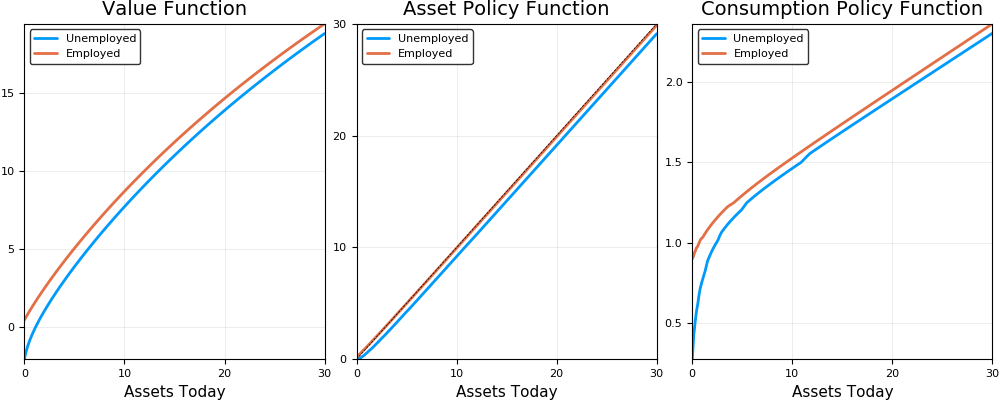

In [10]:
function plot_policies(h::Household)
    
    labs = reshape(["Unemployed", "Employed"], 1, 2)
    plt_v = plot(h.a_grid, h.V, label=labs, lw=2, title = "Value Function", xlabel="Assets Today")
    plt_ap = plot(h.a_grid, h.ap, label=labs, lw=2, title = "Asset Policy Function", xlabel="Assets Today")
    plot!(h.a_grid, h.a_grid, color=:black, linestyle=:dash, lw=0.5, label="")
    plt_c = plot(h.a_grid, h.c, label=labs, lw=2, title = "Consumption Policy Function", xlabel="Assets Today")
    plot(plt_v, plt_ap, plt_c, layout=(1, 3), size=(1000, 400))
    
end

plot_policies(h)

In [11]:
h = Household(;Na=7000);
@time vfi!(h)

Iteration 50, distance 0.38149422466877425
Iteration 100, distance 0.06966792637230412
Iteration 150, distance 0.013525481521678984
Iteration 200, distance 0.000739719665276084
Iteration 250, distance 8.977807224042067e-5
Iteration 300, distance 1.1276834968043659e-5
Iteration 350, distance 1.449225191407777e-6
Iteration 400, distance 1.8781478061669077e-7
Iteration 450, distance 2.438638802004789e-8
Converged in 473 iterations!
 71.028029 seconds (459.38 M allocations: 28.539 GiB, 10.45% gc time)


## Comparitive Statics Exercise: Part 1

We are going to lower the level of unemployment benefits from 0.25 to 0.15 and examine how households' decision rules change. Another way to think of this is that we are increasing the variance of the income process. Using the functions above:
* Create a new `Household` object with the new parameters (500 points on the asset grid is more than enough)
* Solve the problem
* Plot the consumption policy functions against the ones from the original setup

<button data-toggle="collapse" data-target="#sol2" class='btn btn-primary'>Solution</button>
<div id="sol2" class="collapse">
```julia
# Setup and solution
h_ylow = Household(;Na=500, y_chain=MarkovChain([0.5 0.5; 0.04 0.96], [0.15; 1.0]))
@time vfi!(h_ylow)

# Plotting policies
plt_c = plot(h.a_grid, h.c, color=[:red :blue], label=["Unemployed, high UI" "Employed, high UI"])
plot!(h_ylow.a_grid, h_ylow.c, linestyle=:dash, color=[:red :blue], label=["Unemployed, low UI" "Employed, low UI"])
plot!(title="Consumption Policies", xtitle="Assets Today")
```

## Simulation

After solving for the policy functions as we did above, we can simulate paths for the variables of interest. 

The following function simulates a panel of `N` households for `T` periods. The major steps are:
* Set a seed for the random number generator so that we get the same path of shocks each time the function is called
* Use `QuantEcon`'s `MarkovChain` class to simulate `N` paths of the Markov chain for income in advance.
* Create a linear interpolant of the solved asset policy function so that we can compute approximate asset policies off the grid.
* Back out simulated consumption from the budget constraint using assets today and the interpolated asset policy

Below, I simulate a panel of 20,000 households for 1000 periods. I start each household off with $a_0 = 20$ and plot some of the resulting paths.

In [12]:
function simulate_h(h::Household, N::Int64=20000, T::Int64=1000, a0::Float64=20.0)
	
	srand(43)

	# Simulate Markov chain
	y_sim = Array{Int64}(T, N)
	simulate_indices!(y_sim, h.y_chain)

	# Set up matrix to store consumption and asset policies
	a_sim = Array{Float64}(T+1, N)
	a_sim[1, :] = a0*ones(1, N)
	c_sim = Array{Float64}(T, N)

	# Create interpolation object for final asset policy
	knots = (h.a_grid, [1, 2])
    itp_a = interpolate(knots, h.ap, (Gridded(Linear()), NoInterp()))

    for n = 1:N
    	for t = 1:T

    		# Interpolate a_{t+1}
    		a_sim[t + 1, n] = itp_a[a_sim[t, n], y_sim[t, n]]
    		c_sim[t, n] = budget_constraint(a_sim[t, n], a_sim[t + 1, n], h.y_grid[y_sim[t, n]], h)

    	end
    end
    
    return a_sim, c_sim, y_sim

end 

simulate_h (generic function with 4 methods)

In [19]:
@time a_sim, c_sim, y_sim = simulate_h(h)

  2.020613 seconds (20.05 k allocations: 459.293 MiB, 1.33% gc time)


([20.0 20.0 … 20.0 20.0; 19.1364 19.1364 … 19.1364 19.9014; … ; 3.27696 2.22842 … 1.6652 2.3062; 3.28419 2.26702 … 1.72718 2.34205], [1.89606 1.89606 … 1.89606 1.94855; 1.86075 1.86075 … 1.91267 1.94446; … ; 1.20682 1.13306 … 1.08566 1.13906; 1.20729 1.13608 … 1.0913 1.14178], [1 1 … 1 2; 1 1 … 2 2; … ; 2 2 … 2 2; 2 2 … 2 2])

Let's first look at a typical realization for a single agent:


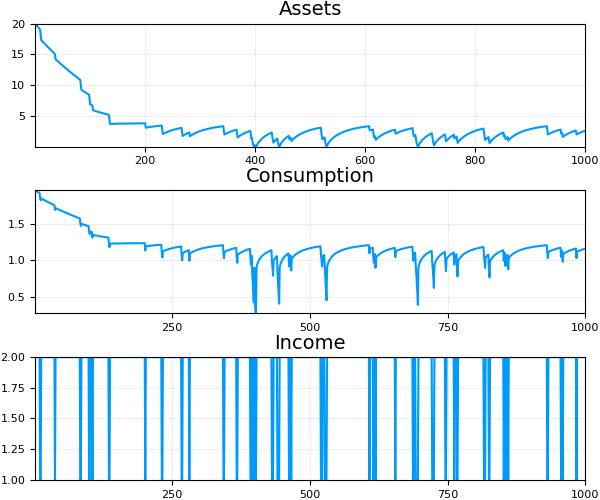

In [14]:
plt_a = plot(a_sim[:, 7], legend=:none, title="Assets", lw=1.5)
plt_c = plot(c_sim[:, 7], legend=:none, title="Consumption", lw=1.5)
plt_y = plot(y_sim[:, 7], legend=:none, title="Income", lw=1.5)
plot(plt_a, plt_c, plt_y, layout=(3,1), size=(600,500))

The downward spikes in assets and consumption line up with the realizations of the low income shock (or "unemployment"). They don't last long, but between them, the household builds up its asset stock to insure for the next one.

Here's what the paths for the first 100 households look like:


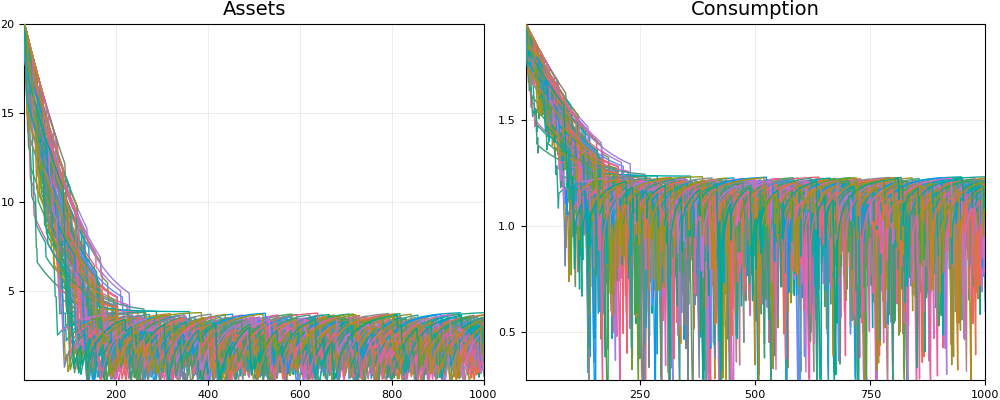

In [15]:
plt_a = plot(a_sim[:, 1:100], legend=:none, title="Assets")
plt_c = plot(c_sim[:, 1:100], legend=:none, title="Consumption")
plot(plt_a, plt_c, layout=(1,2), size=(1000,400))

## Evolution of Distribution

From the charts above, it's clear that the asset holdings of the agents are settling down to a certain region of the state space. This is an illustration of the concept of a *stationary distribution*. In the long run, even though individual agents move around the income and wealth distribution, the distributions themselves remain constant period to period.

We can examine the shape and convergence of the stationary distribution by examining the simulated paths we generated above (note: in practice, simulation is not the ideal way to compute this).

In [16]:
@everywhere function plot_distributions(h::Household, a_sim::AbstractArray, y_sim::Matrix{Int64}; kmax::Float64=4.0)

    times = [150, 200, 300, 500, 1000]

    density_range = 0:0.05:kmax
    histograms_u = Array{StatsBase.Histogram, 1}(length(times))
    histograms_e = Array{StatsBase.Histogram, 1}(length(times))
    kds_u = Array{KernelDensity.UnivariateKDE, 1}(length(times))
    kds_e = Array{KernelDensity.UnivariateKDE, 1}(length(times))
    kdu_data = zeros(length(density_range), length(times))
    kde_data = zeros(length(density_range), length(times))

    # Compute histograms and kernel densities of distribution at each t
    i = 1
    for t in times

        assets = vec(a_sim[t, :])
        incomes = vec(y_sim[t, :])
        unemp = (incomes.==1)
        emp = (incomes.==2)
        assets_unemp = assets[unemp]
        assets_emp = assets[emp]

        histograms_u[i] = fit(Histogram, assets_unemp, nbins=75, closed=:left)
        histograms_e[i] = fit(Histogram, assets_emp, nbins=75, closed=:left)
        kds_u[i] = kde(assets_unemp)
        kds_e[i] = kde(assets_emp)

        kdu_data[:, i] = pdf(kds_u[i], density_range)
        kde_data[:, i] = pdf(kds_e[i], density_range)

        i = i + 1

    end

    # Plot for employed
    max_dens = maximum(kde_data)
    max_hist = maximum(histograms_e[5].weights)
    plt_e = bar(histograms_e[5].edges, histograms_e[5].weights.*(max_dens/max_hist),
        alpha=0.7, color=:darkslateblue, lw=0.5)
    plot!(density_range, kde_data, lw=1.5, 
        color=[:gray80 :gray70 :gray50 :gray30 :gray10], 
        legend=:none, title="Distribution of Assets: Employed")

    # Plot for unemployed
    max_dens = maximum(kdu_data)
    max_hist = maximum((histograms_u[5].weights)[2:end])
    plt_u = bar(histograms_u[5].edges, histograms_u[5].weights.*(max_dens/max_hist),
        alpha=0.7, color=:darkslateblue, lw=0.5)
    plot!(density_range, kdu_data, lw=1.5, 
        color=[:gray80 :gray70 :gray50 :gray30 :gray10], 
        legend=:none, title="Distribution of Assets: Unemployed")
    
    # Average asset holdings
    avg_a = mean(vec(a_sim[end, :]))
    println("Mean asset holdings: $(avg_a)")
    
    # Fraction of borrowing constrained agents
    bc = 0
    N = size(a_sim, 2)
    for n = 1:N
        if isapprox(a_sim[end, n], 0; atol=1e-9)
            bc = bc + 1
        end
    end
    println("Fraction constrained: $(bc/N)")

    plt = plot(plt_e, plt_u, layout=(2,1), size=(600, 600))
    
    return plt

end

Mean asset holdings: 2.2694265684862023
Fraction constrained: 0.0042



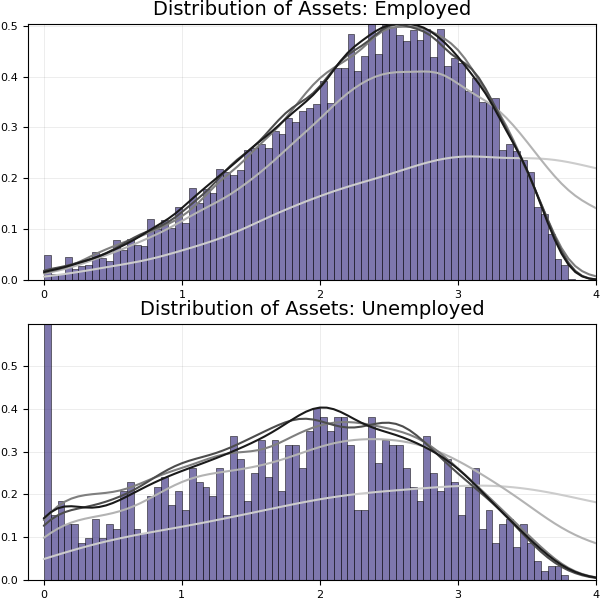

In [17]:
plot_distributions(h, a_sim, y_sim)

The histograms above show the distribution of assets for both employed and unemployed households. The gray lines plot the kernel densities of these distributions at $t = 150, 200, 300, 500, 1000$ (lightest gray to darkest gray). The distribution stabilizes as $t$ increases and the initial state becomes irrelevant. The unemployed also hold less assets on average compared to the employed because they have less income to use to save and because they run down their current assets to be able to smooth consumption while in this state. There is also a mass point of agents who hit the borrowing constraint.

## Exercise: Part 2

Let's look at how the long-run distribution of assets changes in the economy with the low UI benefits. Using the functions above:
* Run a simulation
* Compare the mean level of savings and fraction of borrowing constrained agents to the original setup

<button data-toggle="collapse" data-target="#sol3" class='btn btn-primary'>Solution</button>
<div id="sol3" class="collapse">
```julia
# Simulation and distributions
@time a_sim_ylow, c_sim_ylow, y_sim_ylow = simulate_h(h_ylow)
plot_distributions(h_ylow, a_sim_ylow, y_sim_ylow; kmax=5.5)
```

There are two effects going on here: 
1. The higher income uncertainty drives households to save more (leaving less leftover for consumption).
2. With lower benefit levels, households in general have less resources available.
Together, these lead to an outcome where in the long run, households save more and consume less/

## Parallelization

See notebook ifp_parallel.ipynb.